In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indic-tts-deepfake-challenge/sample.csv


In [2]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 72.0 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0


In [3]:
# Install dependencies
!pip install transformers datasets torchaudio scikit-learn matplotlib seaborn pandas numpy tqdm

In [4]:
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader, IterableDataset
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [5]:
# Set random seed and device
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Step 1: Load pretrained Wav2Vec 2.0 model and processor
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
base_model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53").to(device)
base_model.eval()  # Freeze initially

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:315: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [7]:
# Step 2: Load dataset with streaming
try:
    dataset = load_dataset("SherryT997/IndicTTS-Deepfake-Challenge-Data", streaming=True)
    train_dataset = dataset["train"]
    test_dataset = dataset["test"]
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

README.md:   0%|          | 0.00/2.81k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/35 [00:00<?, ?it/s]

In [9]:
# Step 3: Define iterable dataset
class StreamingAudioDataset(IterableDataset):
    def __init__(self, dataset, subset_size=None, max_samples=None):
        self.dataset = dataset
        self.subset_size = subset_size
        self.max_samples = max_samples
        self.processor = processor
    
    def __iter__(self):
        count = 0
        for sample in self.dataset:
            if self.max_samples and count >= self.max_samples:
                break
            if self.subset_size and count >= int(self.subset_size * 31000):  # Assuming 31K train samples
                break
            
            audio_array = sample["audio"]["array"]
            sampling_rate = sample["audio"]["sampling_rate"]
            is_tts = sample["is_tts"] if "is_tts" in sample else None
            
            # Resample to 16kHz
            if sampling_rate != 16000:
                resampler = torchaudio.transforms.Resample(sampling_rate, 16000)
                audio_array = resampler(torch.tensor(audio_array).float()).numpy()
            
            # Truncate/pad to 10s
            max_length = 160000
            if len(audio_array) > max_length:
                audio_array = audio_array[:max_length]
            else:
                audio_array = np.pad(audio_array, (0, max_length - len(audio_array)), mode='constant')
            
            # Augmentation to mimic indic-parler-tts (real audio only)
            if is_tts == 0 and np.random.rand() < 0.3:
                audio_array = np.convolve(audio_array, np.ones(100)/100, mode='same')
                noise = np.random.normal(0, 0.005, audio_array.shape)
                audio_array = audio_array + noise
            
            # Process audio
            inputs = self.processor(audio_array, sampling_rate=16000, return_tensors="pt", padding=True)
            yield {
                "input_values": inputs.input_values.squeeze(0),
                "label": is_tts,
                "id": sample["id"]
            }
            count += 1

In [10]:
# Trial run on 10% of training data
subset_size = 0.3  # ~3K samples
train_dataset_iter = StreamingAudioDataset(train_dataset, subset_size=subset_size)
train_loader = DataLoader(train_dataset_iter, batch_size=8)

In [11]:
# Validation subset (next 20% of 3K)
val_dataset_iter = StreamingAudioDataset(train_dataset.skip(int(subset_size * 31000)), max_samples=int(0.02 * 31000))  # ~620 samples
val_loader = DataLoader(val_dataset_iter, batch_size=8)

In [12]:
# Step 4: Define classifier model (no sigmoid)
class Wav2Vec2Classifier(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)  # Output logits, no sigmoid
        )
    
    def forward(self, input_values):
        with torch.no_grad():
            outputs = self.base_model(input_values).last_hidden_state  # [batch, seq_len, 1024]
        pooled_output = outputs.mean(dim=1)  # [batch, 1024]
        return self.classifier(pooled_output)

In [13]:
model = Wav2Vec2Classifier(base_model).to(device)

In [14]:
# Step 5: Training setup (use BCEWithLogitsLoss)
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=5e-4)  #1e-4
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid and BCE
scaler = torch.cuda.amp.GradScaler()

<ipython-input-14-03eea30ccb7d>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [15]:
def train_epoch(loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    batches = 0
    for batch in tqdm(loader, desc="Training"):
        input_values = batch["input_values"].to(device)
        labels = batch["label"].float().to(device)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(input_values)  # Raw logits
            loss = criterion(logits.squeeze(), labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        batches += 1
    return total_loss / batches if batches > 0 else 0

In [16]:
def evaluate(loader, model):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_values = batch["input_values"].to(device)
            labels = batch["label"].float().to(device)
            logits = model(input_values)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities for evaluation
            preds.extend(probs.squeeze().cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return preds, targets

In [17]:
# Train for 3 epochs
print("Training model...")
for epoch in range(8):
    train_loss = train_epoch(train_loader, model, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

Training model...


Training: 0it [00:00, ?it/s]<ipython-input-15-8756537a7e92>:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 1163it [08:41,  2.23it/s]


Epoch 1, Loss: 0.6388


Training: 1163it [08:34,  2.26it/s]


Epoch 2, Loss: 0.5849


Training: 1163it [08:32,  2.27it/s]


Epoch 3, Loss: 0.5535


Training: 1163it [08:29,  2.28it/s]


Epoch 4, Loss: 0.5198


Training: 1163it [08:32,  2.27it/s]


Epoch 5, Loss: 0.4793


Training: 1163it [08:30,  2.28it/s]


Epoch 6, Loss: 0.4654


Training: 1163it [08:39,  2.24it/s]


Epoch 7, Loss: 0.4426


Training: 1163it [08:32,  2.27it/s]

Epoch 8, Loss: 0.4209


In [18]:
# Step 6: Evaluate on train and validation sets
train_dataset_iter = StreamingAudioDataset(train_dataset, subset_size=subset_size)
train_loader = DataLoader(train_dataset_iter, batch_size=8)
train_preds, train_targets = evaluate(train_loader, model)
val_preds, val_targets = evaluate(val_loader, model)

Evaluating: 1163it [23:06,  1.19s/it]
Evaluating: 78it [02:45,  2.13s/it]


In [19]:
train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)
print(f"Train ROC-AUC: {train_auc:.4f}")
print(f"Validation ROC-AUC: {val_auc:.4f}")

Train ROC-AUC: 0.9021
Validation ROC-AUC: 0.9025


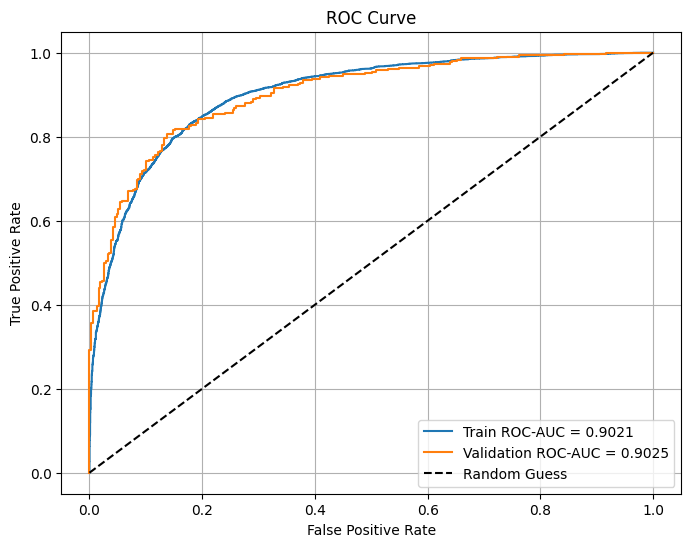

In [20]:
# Visualization: ROC Curve
fpr_train, tpr_train, _ = roc_curve(train_targets, train_preds)
fpr_val, tpr_val, _ = roc_curve(val_targets, val_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f"Train ROC-AUC = {train_auc:.4f}")
plt.plot(fpr_val, tpr_val, label=f"Validation ROC-AUC = {val_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("roc_curve.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


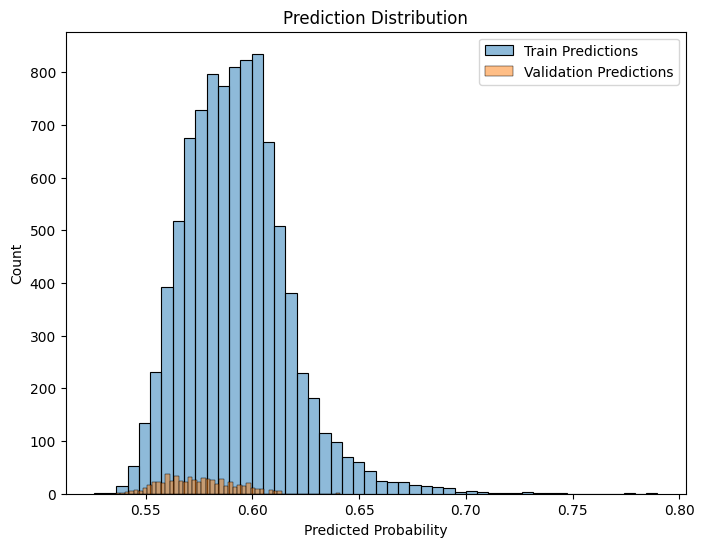

In [21]:
# Visualization: Prediction Distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_preds, bins=50, label="Train Predictions", alpha=0.5)
sns.histplot(val_preds, bins=50, label="Validation Predictions", alpha=0.5)
plt.xlabel("Predicted Probability")
plt.title("Prediction Distribution")
plt.legend()
plt.savefig("pred_distribution.png")
plt.show()

In [22]:
# Step 7: Process test data
test_dataset_iter = StreamingAudioDataset(test_dataset, max_samples=2635)
test_loader = DataLoader(test_dataset_iter, batch_size=8)

In [23]:
def predict(loader, model):
    model.eval()
    preds, ids = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Predicting Test"):
            input_values = batch["input_values"].to(device)
            logits = model(input_values)
            probs = torch.sigmoid(logits)  # Convert logits to probabilities
            preds.extend(probs.squeeze().cpu().numpy())
            ids.extend(batch["id"])
    return ids, preds

In [24]:
test_ids, test_preds = predict(test_loader, model)

Predicting Test: 330it [06:18,  1.15s/it]


In [25]:
# Step 8: Generate submission
submission = pd.DataFrame({"id": test_ids, "is_tts": test_preds})
submission.to_csv("submission.csv", index=False)
print("Submission saved as submission.csv")
print(submission.head())
print(f"Submission shape: {submission.shape}")

Submission saved as submission.csv
                  id    is_tts
0  ASM_F_ANGER_00109  0.586920
1  ASM_F_ANGER_00127  0.594088
2  ASM_F_ANGER_00386  0.613568
3  ASM_F_ANGER_00103  0.596893
4  ASM_F_ANGER_00434  0.585730
Submission shape: (2635, 2)
